# Importing the data and other libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
pd.set_option('float_format', '{:,.0f}'.format)

dataset = pd.read_csv('sensibank-aggregate-data.csv')

# Inspecting the imported data

In [2]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11589 entries, 0 to 11588
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Store Location                    11589 non-null  object 
 1   Transaction Date                  11589 non-null  object 
 2   Weekday                           11589 non-null  object 
 3   Working Day                       11589 non-null  object 
 4   Number of Bank Card Transactions  11589 non-null  float64
 5   Number of Off-Card Transactions   11589 non-null  int64  
 6   Bank Card Spend                   11589 non-null  float64
 7   Off-Card Spend                    11589 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 724.4+ KB
None


In [3]:
print(dataset.describe())

       Number of Bank Card Transactions  Number of Off-Card Transactions  \
count                            11,589                           11,589   
mean                                 75                               56   
std                                  53                               39   
min                                   0                                0   
25%                                  39                               25   
50%                                  63                               50   
75%                                  94                               78   
max                                 575                              310   

       Bank Card Spend  Off-Card Spend  
count           11,589          11,589  
mean           373,733         187,746  
std            289,538         150,235  
min                  0               0  
25%            174,200          79,100  
50%            311,000         158,600  
75%            485,600      

In [4]:
print(dataset.nunique())

Store Location                         5
Transaction Date                    2427
Weekday                               14
Working Day                            2
Number of Bank Card Transactions    1056
Number of Off-Card Transactions      237
Bank Card Spend                     6599
Off-Card Spend                      4282
dtype: int64


In [5]:
print(dataset.isnull().sum())

Store Location                      0
Transaction Date                    0
Weekday                             0
Working Day                         0
Number of Bank Card Transactions    0
Number of Off-Card Transactions     0
Bank Card Spend                     0
Off-Card Spend                      0
dtype: int64


# Data wrangling and feature engineering

In [6]:
# Converting numbers from int to float
dataset['Number of Off-Card Transactions'] = dataset['Number of Off-Card Transactions'].astype('float')
dataset['Off-Card Spend'] = dataset['Off-Card Spend'].astype('float')

In [7]:
# Convert date column to datetime and setting as index
dataset['Transaction Date'] = pd.to_datetime(dataset['Transaction Date'])

In [8]:
# Convert all Upper case in Weekday column to Title case week days are 7 not 14
dataset['Weekday'].nunique()

14

In [9]:
dataset['Weekday'] = dataset['Weekday'].str.title()

In [10]:
dataset['Weekday'].nunique()

7

In [11]:
# 'Number of Bank Card Transactions' number of transaction cant be decimal and needs to be a whole number
dataset['Number of Bank Card Transactions'] = dataset['Number of Bank Card Transactions'].round(0)

## Case 1.1 Frequency (Identifying locations where their co-branded card is not being used as often)

In [12]:
# Co Branded Card
co_branded_card_freq = dataset.groupby('Store Location')['Number of Bank Card Transactions'].sum().sort_values(ascending=True)
co_branded_freq_rank = co_branded_card_freq.rank()
co_branded_freq_rank = pd.merge(co_branded_card_freq, co_branded_freq_rank, on='Store Location').reset_index()
co_branded_freq_rank.columns = ['Store Location', 'Number of Bank Card Transactions', 'Co Branded Rank']
co_branded_freq_rank

,Store Location,Number of Bank Card Transactions,Co Branded Rank
0,Big Street,"110,015",1
1,University Avenue,"118,955",2
2,Airport,"152,231",3
3,Mount Road,"197,215",4
4,King Street,"288,624",5


# Exploiting competitors data

In [13]:
# Competitors
off_card_freq = dataset.groupby('Store Location')['Number of Off-Card Transactions'].sum().sort_values(ascending=False)
off_card_freq_rank = off_card_freq.rank()
off_card_freq_rank = pd.merge(off_card_freq, off_card_freq_rank, on='Store Location').reset_index()
off_card_freq_rank.columns = ['Store Location', 'Number of Off-Card Transactions', 'Off-Card Rank']
off_card_freq_rank

,Store Location,Number of Off-Card Transactions,Off-Card Rank
0,University Avenue,"172,252",5
1,Mount Road,"170,102",4
2,Big Street,"138,292",3
3,King Street,"113,234",2
4,Airport,"52,478",1


In [14]:
# Merging the Co Branded Number of Transaction with the Competitors'
cards = pd.merge(co_branded_freq_rank, off_card_freq_rank, how='right', on='Store Location')

# Adding Percentage column to compare the Co Branded Number of Transaction with the Competitors'
cards['% Cards Market Share'] = round(
    (cards['Number of Bank Card Transactions'] / 
     (cards['Number of Bank Card Transactions'] + cards['Number of Off-Card Transactions']) 
     * 100), 2)
cards.sort_values('Co Branded Rank').reset_index().drop('index', axis=1)

,Store Location,Number of Bank Card Transactions,Co Branded Rank,Number of Off-Card Transactions,Off-Card Rank,% Cards Market Share
0,Big Street,"110,015",1,"138,292",3,44
1,University Avenue,"118,955",2,"172,252",5,41
2,Airport,"152,231",3,"52,478",1,74
3,Mount Road,"197,215",4,"170,102",4,54
4,King Street,"288,624",5,"113,234",2,72


# Observations

Co-Branded Cards is not popular in Big Street and University Avenue	the other three locations are relatively above average.

Converserly, the competitors cover more users in Big Street and University Avenue where Co-Branded is struggling relatively.

More insight is needed in terms of monetary value

## Case 1.2 Monetary Value (Identifying potential high-income areas)

In [15]:
high_income_areas = dataset.groupby('Store Location')['Bank Card Spend'].sum().sort_values(ascending=False)
high_income_areas_rank = high_income_areas.rank()

high_income_areas_rank = pd.merge(high_income_areas, high_income_areas_rank, on='Store Location').reset_index()
high_income_areas_rank.columns = ['Store Location', 'Bank Card Spend', 'Co Branded Rank']
high_income_areas_rank

,Store Location,Bank Card Spend,Co Branded Rank
0,King Street,"1,389,992,600",5
1,Mount Road,"929,527,280",4
2,Airport,"827,094,200",3
3,University Avenue,"639,314,100",2
4,Big Street,"545,265,544",1


# Exploiting competitors data

In [16]:
# Competitors
competitors_high_income_areas = dataset.groupby('Store Location')['Off-Card Spend'].sum().sort_values(ascending=False)
competitors_high_income_areas_rank = competitors_high_income_areas.rank()

competitors_high_income_areas_rank = pd.merge(competitors_high_income_areas, competitors_high_income_areas_rank, on='Store Location').reset_index()
competitors_high_income_areas_rank.columns = ['Store Location', 'Off-Card Spend', 'Off-Card Rank']
competitors_high_income_areas_rank

,Store Location,Off-Card Spend,Off-Card Rank
0,University Avenue,"671,994,900",5
1,King Street,"464,306,700",4
2,Mount Road,"464,168,800",3
3,Big Street,"402,895,600",2
4,Airport,"172,416,900",1


Merging the Co-Branded spend with the competitors

In [17]:
spent = pd.merge(high_income_areas_rank, competitors_high_income_areas_rank, on='Store Location')
spent['% Spend Market Share'] = round(
    (spent['Bank Card Spend'] / 
     (spent['Bank Card Spend'] + spent['Off-Card Spend']) 
     * 100), 2)
spent['Total Spent'] = spent['Bank Card Spend'] + spent['Off-Card Spend']
spent.sort_values('Total Spent', ascending=False)

,Store Location,Bank Card Spend,Co Branded Rank,Off-Card Spend,Off-Card Rank,% Spend Market Share,Total Spent
0,King Street,"1,389,992,600",5,"464,306,700",4,75,"1,854,299,300"
1,Mount Road,"929,527,280",4,"464,168,800",3,67,"1,393,696,080"
3,University Avenue,"639,314,100",2,"671,994,900",5,49,"1,311,309,000"
2,Airport,"827,094,200",3,"172,416,900",1,83,"999,511,100"
4,Big Street,"545,265,544",1,"402,895,600",2,58,"948,161,144"


# Observations

The high-income areas are King Street and Mount Road. Co Branded could exploit more opportunities in University Avenue as it's market share is relatively low. This happens to be the only location the competitors have an edge over us.


Now lets see the values each added in relative to the numbers of transactions. That is, the unit spent in each location

In [18]:
card_spent = pd.merge(spent, cards, on='Store Location').drop(['Co Branded Rank_x', 'Off-Card Rank_x', '% Spend Market Share', 'Total Spent', 'Co Branded Rank_y', 'Off-Card Rank_y', '% Cards Market Share'], axis=1)
card_spent['Store Location'] = card_spent['Store Location']
card_spent['Co_branded_unitSpent'] = card_spent['Bank Card Spend'] / card_spent['Number of Bank Card Transactions']
card_spent['Competitors_unitSpent'] = card_spent['Off-Card Spend'] / card_spent['Number of Off-Card Transactions']
card_spent = card_spent.sort_values('Co_branded_unitSpent', ascending=False).reset_index().drop('index', axis=1)
card_spent

,Store Location,Bank Card Spend,Off-Card Spend,Number of Bank Card Transactions,Number of Off-Card Transactions,Co_branded_unitSpent,Competitors_unitSpent
0,Airport,"827,094,200","172,416,900","152,231","52,478","5,433","3,286"
1,University Avenue,"639,314,100","671,994,900","118,955","172,252","5,374","3,901"
2,Big Street,"545,265,544","402,895,600","110,015","138,292","4,956","2,913"
3,King Street,"1,389,992,600","464,306,700","288,624","113,234","4,816","4,100"
4,Mount Road,"929,527,280","464,168,800","197,215","170,102","4,713","2,729"


# Observations

Co-Branded dominates every locations in terms of efficiency. The unit spent on each transaction is higher compare to the competitors

In terms of values added the above table shows their rank (Co_branded_unitSpent)

## Case 1.3 Identifying stores where their co-branded card usage has gone down over time

In [19]:
# Extracting Features (year) from the date
L = ['year', 'month']
dataset = dataset.join(pd.concat((getattr(dataset['Transaction Date'].dt, i).rename(i) for i in L), axis=1))

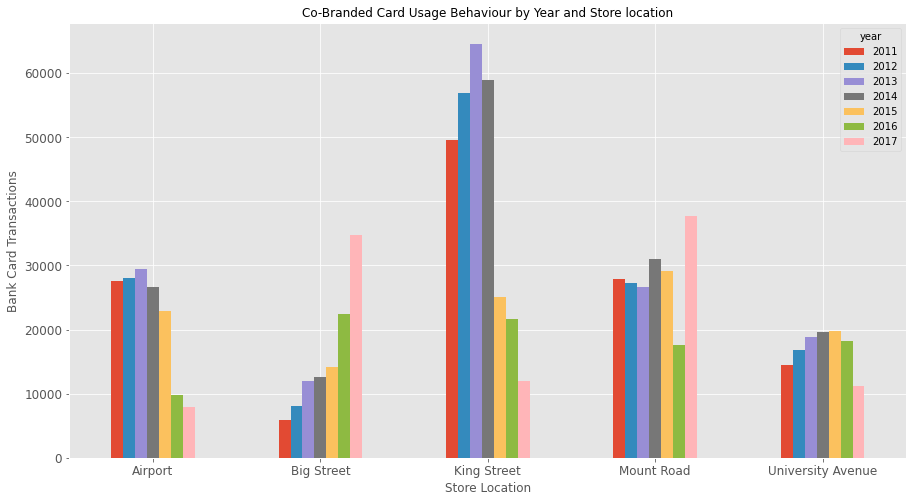

In [20]:
# Visualising co_branded usage behaviour
co_branded_overtime_usage = dataset.groupby(['Store Location', 'year'])['Number of Bank Card Transactions'].sum().unstack('year')
co_branded_overtime_usage.plot(kind = 'bar', fontsize = 12, rot = 0, figsize=(15, 8))
plt.xlabel('Store Location', fontsize = 12)
plt.ylabel('Bank Card Transactions', fontsize = 12)
plt.title('Co-Branded Card Usage Behaviour by Year and Store location', fontsize = 12)
plt.show()

# Observations

Over the years card usage in Airport and King Street as greatly reduce, Also University Avenue but minimal relatively. The 3 mentioned locations are performing poorly in terms of card usage overtime as against Big Street and Mount Road. 

Note: 2017 data ends at Q3

Let's also visualise the competitors data below.

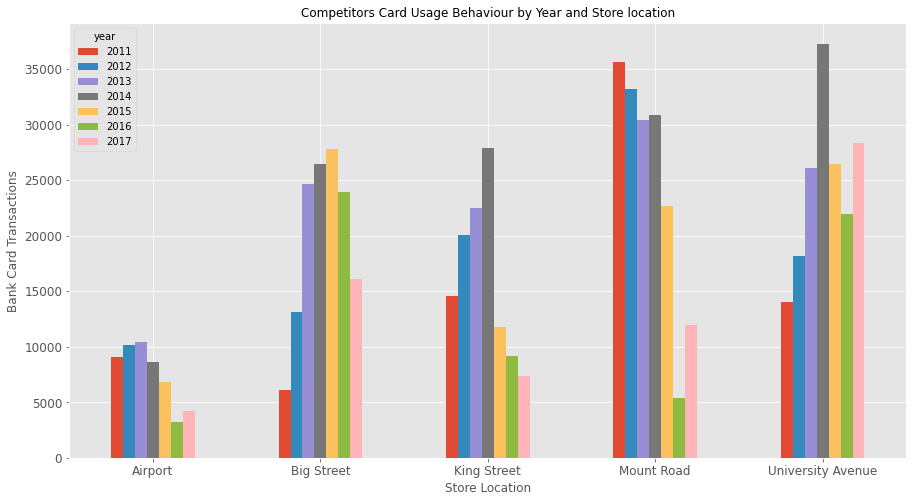

In [21]:
# Visualising competitor usage behaviour
competitors_overtime_usage = dataset.groupby(['Store Location', 'year'])['Number of Off-Card Transactions'].sum().unstack('year')
competitors_overtime_usage.plot(kind = 'bar', fontsize = 12, rot = 0, figsize=(15, 8))
plt.xlabel('Store Location', fontsize = 12)
plt.ylabel('Bank Card Transactions', fontsize = 12)
plt.title('Competitors Card Usage Behaviour by Year and Store location', fontsize = 12)
plt.show()

In [22]:
yearly_cards = dataset.groupby(['Store Location', 'year']).agg({'Number of Bank Card Transactions': 'sum',
                                                 'Number of Off-Card Transactions': 'sum'})
yearly_cards['% Market Share'] = round(
    (yearly_cards['Number of Bank Card Transactions'] / 
     (yearly_cards['Number of Bank Card Transactions'] + yearly_cards['Number of Off-Card Transactions']) 
     * 100), 2)
yearly_cards.reset_index()

,Store Location,year,Number of Bank Card Transactions,Number of Off-Card Transactions,% Market Share
0,Airport,2011,"27,536","9,067",75
1,Airport,2012,"28,078","10,113",74
2,Airport,2013,"29,396","10,399",74
3,Airport,2014,"26,597","8,608",76
4,Airport,2015,"22,823","6,833",77
5,Airport,2016,"9,827","3,200",75
6,Airport,2017,"7,974","4,258",65
7,Big Street,2011,"5,877","6,111",49
8,Big Street,2012,"8,079","13,161",38
9,Big Street,2013,"12,042","24,667",33


In [23]:
yearly_spend = dataset.groupby(['Store Location', 'year']).agg({'Bank Card Spend': 'sum', 'Off-Card Spend': 'sum'})
yearly_spend['% Market Share'] = round(
    (yearly_spend['Bank Card Spend'] / (yearly_spend['Bank Card Spend'] + yearly_spend['Off-Card Spend']) * 100), 2)
yearly_spend.reset_index()

,Store Location,year,Bank Card Spend,Off-Card Spend,% Market Share
0,Airport,2011,"130,016,300","27,976,600",82
1,Airport,2012,"148,346,800","32,237,500",82
2,Airport,2013,"157,525,000","35,413,600",82
3,Airport,2014,"147,617,100","27,675,900",84
4,Airport,2015,"133,554,500","22,759,300",85
5,Airport,2016,"60,868,900","11,593,100",84
6,Airport,2017,"49,165,600","14,760,900",77
7,Big Street,2011,"25,074,100","18,222,200",58
8,Big Street,2012,"38,557,600","36,948,200",51
9,Big Street,2013,"52,389,900","68,066,200",43
